# Notes
* Methods for estimating FAP are still in development for BLS at the time of this tutorial's writing
* Transit is modeled as a "top hat"
* ah I see how to extract not just the best parameters...this solves the issue with BLS I was having when working on the Kepler Experiment
* I really like the periodogram plot they made (both simple harmonics method and looks)
* Seems as if we will use a lot of the code here as a starting point for our own
* bls.compute_stats seems useful
* ```stats['depth']``` returns a tuple in which the first value is the depth and the second value is the associated error
* If ```harmonic_delta_log_likelihood``` is greater than zero, the sinusoidal model is preferred.
* Finally, ```transit_times``` (from ```stats['transit_times']```) is a convenient way to access the times in the data when a transit is thought to have occured
    * Where ```stats = bls.compute_stats(period, duration, t0)``` for a single set of parameters 
* **Important** make sure to remove all ```NaN``` and missing values in the data arrays, or else BLS won't work. 
* lightkurve seems to have lots of cool functions like ```lc.flatten()```
* An alternative to BLS is Transit Least Squares (TLS), which Dr. Bouma seems to be involved with. 
    * TLS fitted feature more realistically resembles transit like features...I wonder if there are any cases where errors come up by using BLS instead of TLS.
    * " A typical Kepler K2 light curve, worth of 90 d of observations at a cadence of 30 min, can be searched with TLS in 10 seconds real time on a standard laptop computer, just as with BLS."
    * Thus...searching for ~50,000 light curves would take around six days?  
* **Great Feature**: it's very easy to mask best period and run periodogram with it hidden with BLS
* Depth significance seems like a cool metric
* "TESS observes large sectors of the sky for 27 days at a time. The overlap of these sectors means that stars near the ecliptic poles will receive a year of uninterrupted data, while those near the ecliptic receive only ~27 days. "

## Questions
* What is log likelihood?
* Is TESS data easier to work with than Kepler data (with regards to e.g. systematics)? Or will using data from northern hemisphere (longer than 27 days as it's nearly continuous there) introduce such issues? 
* Wait...what are these: [link one](https://archive.stsci.edu/hlsps/tess-data-alerts/hlsp_tess-data-alerts_tess_phot_00009725627-s02-01_tess_v1_dvs.pdf) and [link two](https://archive.stsci.edu/hlsps/tess-data-alerts/hlsp_tess-data-alerts_tess_phot_00009725627-s02_tess_v1_dvr.pdf)
    * Ask Dr. Bouma
    * Why the even vs odd plot in the bottom left corner of the first link? 

## Misc.
* BLS original algorithm paper: [link](http://adsabs.harvard.edu/abs/2002A%26A...391..369K)
* tqdm is really cool. Just ```from tqdm import tqdm``` and all you need to do to use it is wrap an iterator, like so: ```for i in tqdm(range(10000)):```
* LOL Dr. Bouma has similiar style preferences to me in his plots (see his aesthetic repo)

### Copy and Pasted from Guide

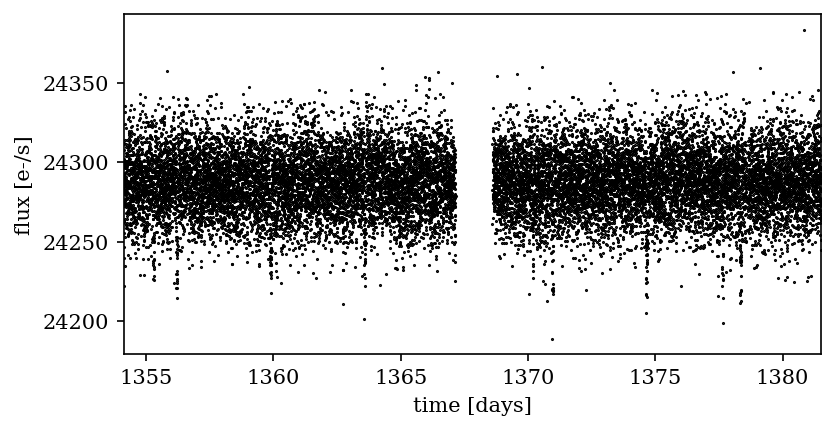

In [6]:
import numpy as np
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams['font.family']='serif'
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

url = "https://archive.stsci.edu/hlsps/tess-data-alerts/hlsp_tess-data-alerts_tess_phot_00307210830-s02_tess_v1_lc.fits"

# Download and read the light curve file
with fits.open(url) as hdus:
    data = hdus[1].data
    time = data["TIME"]
    flux = data["PDCSAP_FLUX"]
    flux_err = data["PDCSAP_FLUX_ERR"]
    quality = data["QUALITY"]

# Mask out any data with imperfect quality
m = (quality == 0) # didn't know you could mask like this
time = time[m]
flux = flux[m]
flux_err = flux_err[m]

# Plot the light curve
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 3))
ax.plot(time, flux, ".k", ms=1)
ax.set_xlim([time.min(), time.max()])
ax.set_xlabel("time [days]")
ax.set_ylabel("flux [e-/s]");    

In [3]:
print(m)

[False False False ...  True  True  True]


In [9]:
periods = np.linspace(0.5, 20, 10)
durations = np.linspace(0.05, 0.2, 10)

from astropy.stats import BoxLeastSquares
bls = BoxLeastSquares(t=time, y=flux, dy=flux_err)
results = bls.autopower(durations, frequency_factor=5.0)

In [12]:
list(results.keys())

['objective',
 'period',
 'power',
 'depth',
 'depth_err',
 'duration',
 'transit_time',
 'depth_snr',
 'log_likelihood']

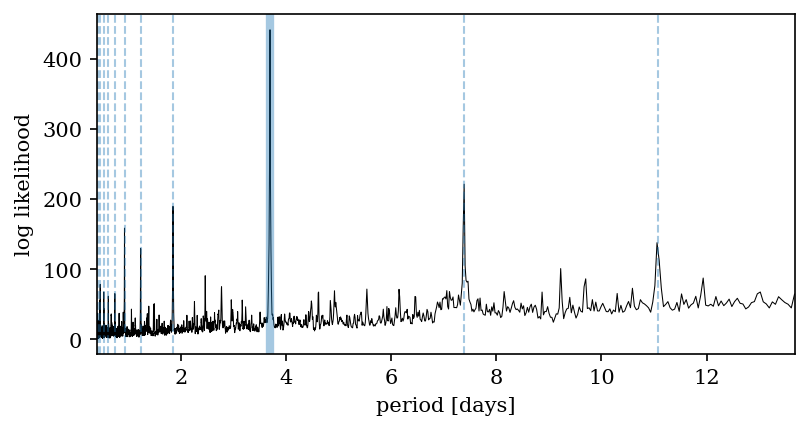

In [13]:
# Find the period of the peak
period = results.period[np.argmax(results.power)]

# Plot the periodogram
rcParams["figure.dpi"] = 150
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(results.period, results.power, "k", lw=0.5)
ax.set_xlim(results.period.min(), results.period.max())
ax.set_xlabel("period [days]")
ax.set_ylabel("log likelihood")

# Highlight the harmonics of the peak period
ax.axvline(period, alpha=0.4, lw=4)
for n in range(2, 10):
    ax.axvline(n*period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(period / n, alpha=0.4, lw=1, linestyle="dashed")

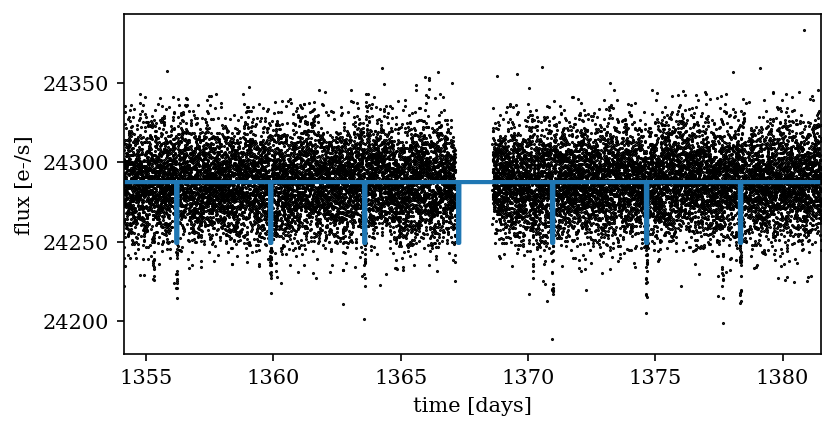

In [14]:
# Extract the parameters of the best-fit model
index = np.argmax(results.power)
period = results.period[index]
t0 = results.transit_time[index]
duration = results.duration[index]

# Plot the light curve and best-fit model
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(time, flux, ".k", ms=1)
x = np.linspace(time.min(), time.max(), 3*len(time))
model_flux = bls.model(x, period, duration, t0) # nice trick here
ax.plot(x, model_flux, lw=2)
ax.set_xlim(time.min(), time.max())
ax.set_xlabel("time [days]")
ax.set_ylabel("flux [e-/s]");

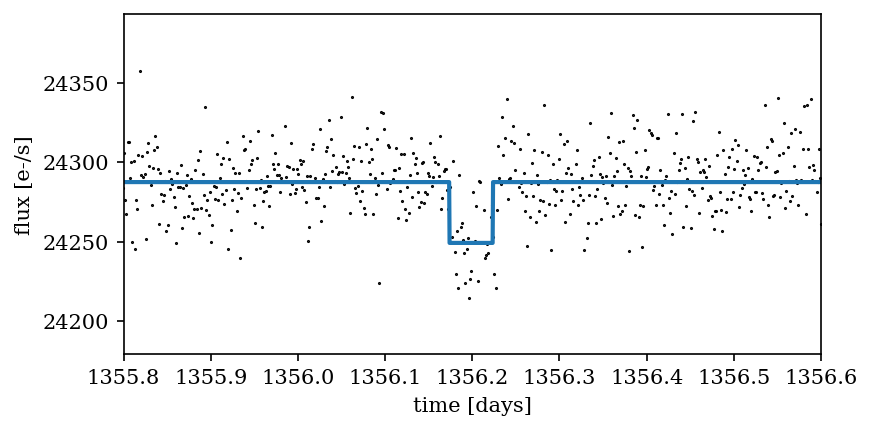

In [15]:
# Zoom in on the first transit
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(time, flux, ".k", ms=1)
x = np.linspace(time.min(), time.max(), 3*len(time))
model_flux = bls.model(x, period, duration, t0)
ax.plot(x, model_flux, lw=2)
ax.set_xlim(1355.8, 1356.6)
ax.set_xlabel("time [days]")
ax.set_ylabel("flux [e-/s]");

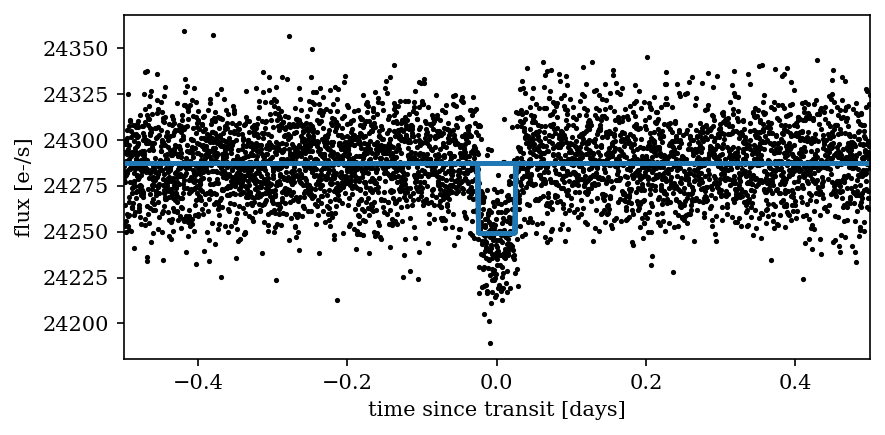

In [16]:
# Plot the folded data points within 0.5 days of the transit time
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
phase = (time - t0 + 0.5*period) % period - 0.5*period
m = np.abs(phase) < 0.5
ax.plot(phase[m], flux[m], ".k", ms=3)

# Over-plot the best fit model
x = np.linspace(-0.5, 0.5, 1000)
model_flux = bls.model(phase + t0, period, duration, t0)
ax.plot(phase, model_flux, lw=2)
ax.set_xlim(-0.5, 0.5)
ax.set_xlabel("time since transit [days]")
ax.set_ylabel("flux [e-/s]")
plt.tight_layout()

In [17]:
stats = bls.compute_stats(period, duration, t0)
stats

{'transit_times': array([1356.19882313, 1359.89056904, 1363.58231495, 1367.27406087,
        1370.96580678, 1374.65755269, 1378.34929861]),
 'per_transit_count': array([31, 36, 36,  0, 36, 36, 36]),
 'per_transit_log_likelihood': array([48.41892735, 83.05181652, 57.84058709,  0.        , 77.63318712,
        99.38903173, 75.2801366 ]),
 'depth': (38.22634221346743, 1.293831881221091),
 'depth_phased': (0.1236649944949022, 1.1259926704811867),
 'depth_half': (16.507922143930045, 0.8551289839428252),
 'depth_odd': (42.25020111836784, 2.206216998938872),
 'depth_even': (36.14164297219031, 1.5909571409358478),
 'harmonic_amplitude': 0.8187286213780722,
 'harmonic_delta_log_likelihood': -427.741813303448}

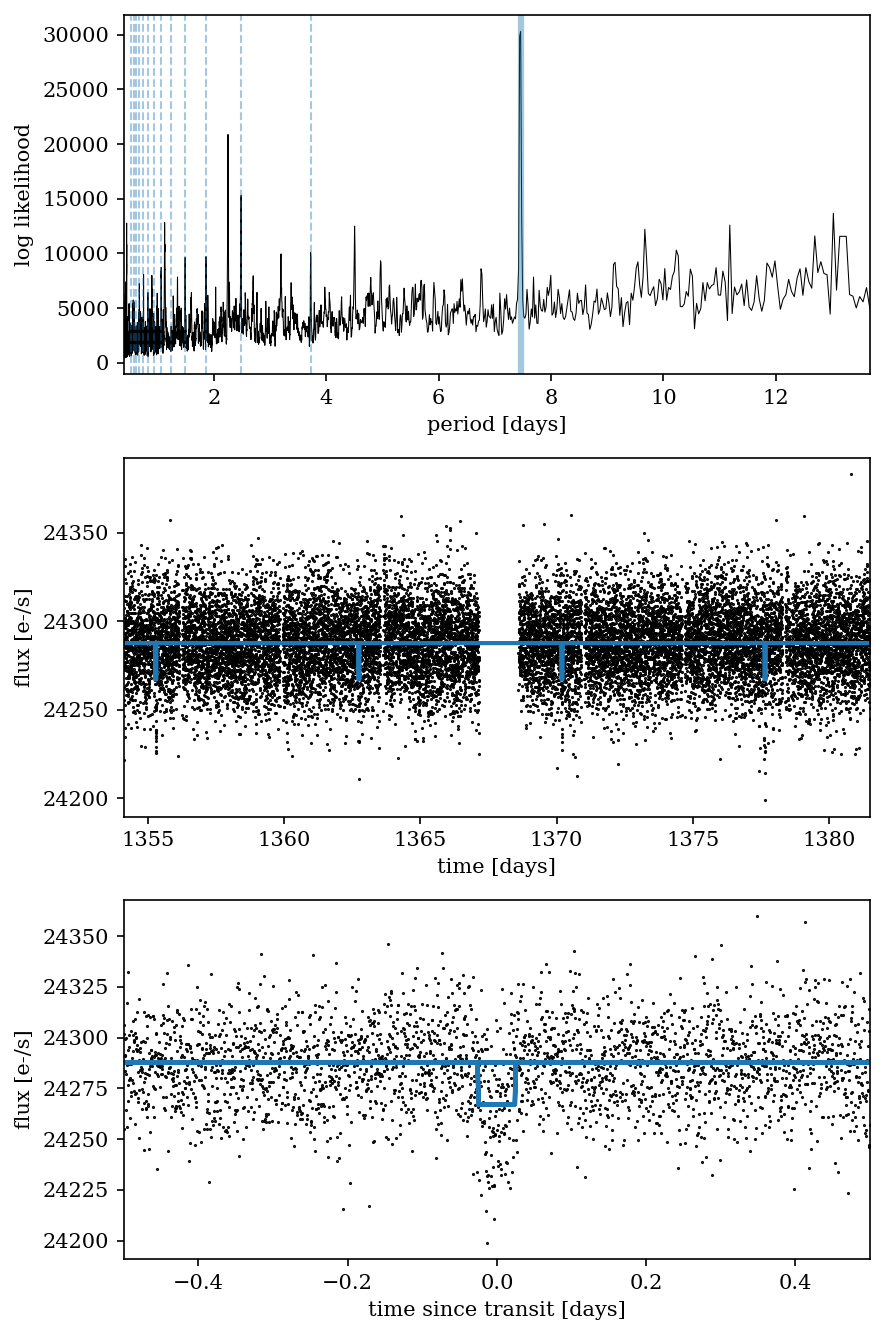

In [21]:
# Find the in-transit points using a longer duration as a buffer to avoid ingress and egress
in_transit = bls.transit_mask(time, period, 2*duration, t0)

# Re-run the algorithm, and plot the results
bls2 = BoxLeastSquares(time[~in_transit], flux[~in_transit])
results2 = bls2.autopower(durations, frequency_factor=5.0)

# Extract the parameters of the best-fit model
index = np.argmax(results2.power)
period2 = results2.period[index]
t02 = results2.transit_time[index]
duration2 = results2.duration[index]

# Plot the periodogram
fig, axes = plt.subplots(3, 1, figsize=(6, 9))
ax = axes[0]
ax.plot(results2.period, results2.power, "k", lw=0.5)
ax.set_xlim(results2.period.min(), results2.period.max())
ax.set_xlabel("period [days]")
ax.set_ylabel("log likelihood")

# Highlight the harmonics of the peak period

ax.axvline(period2, alpha=0.4, lw=3)
for n in range(2, 15):
    ax.axvline(n*period2, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(period2 / n, alpha=0.4, lw=1, linestyle="dashed")

# Plot the light curve
ax = axes[1]
ax.plot(time[~in_transit], flux[~in_transit], ".k", ms=1)
x = np.linspace(time.min(), time.max(), 3*len(time))
f = bls2.model(x, period2, duration2, t02)
ax.plot(x, f, lw=2)
ax.set_xlim(time.min(), time.max())
ax.set_xlabel("time [days]")
ax.set_ylabel("flux [e-/s]");

# Plot the best fit model
ax = axes[2]
phase = (time[~in_transit] - t02 + 0.5*period2) % period2 - 0.5*period2
m = np.abs(phase) < 0.5
ax.plot(phase[m], flux[~in_transit][m], ".k", ms=1)
x = np.linspace(-0.5, 0.5, 1000)
f = bls2.model(phase + t02, period2, duration2, t02)
ax.plot(phase, f, lw=2)
ax.set_xlim(-0.5, 0.5)
ax.set_xlabel("time since transit [days]")
ax.set_ylabel("flux [e-/s]")
plt.tight_layout()

C:\Users\Research\AppData\Local\Temp/ipykernel_18628/788775106.py:4: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  lc = lk.search_lightcurvefile("Kepler-10", quarter=6).download().SAP_FLUX.remove_nans()
C:\Users\Research\AppData\Local\Programs\Python\Python38\lib\site-packages\lightkurve\search.py:346: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
C:\Users\Research\AppData\Local\Temp/ipykernel_18628/788775106.py:4: LightkurveDeprecationWarning: The SAP_FLUX function is deprecated and may be removed in a future version.
  lc = lk.search_lightcurvefile("Kepler-10", quarter=6).download().SAP_FLUX.remove_nans()


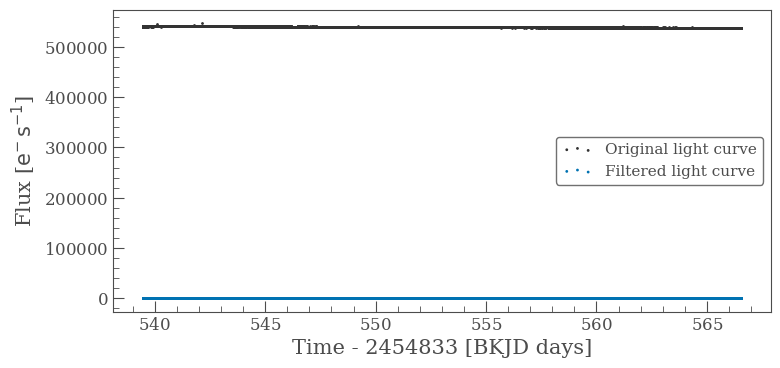

In [20]:
import lightkurve as lk

# Plot the original light curve
lc = lk.search_lightcurvefile("Kepler-10", quarter=6).download().SAP_FLUX.remove_nans()
ax = lc.scatter(label="Original light curve")

# Plot the filtered light curve
lc_flat = lc.flatten()
lc_flat.scatter(ax=ax, label="Filtered light curve");

### Exercises

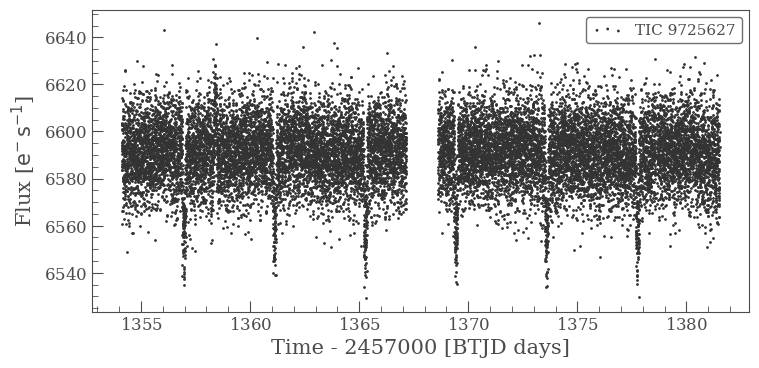

In [23]:
tic = '9725627'
url = "https://archive.stsci.edu/hlsps/tess-data-alerts/hlsp_tess-data-alerts_tess_phot_00009725627-s02_tess_v1_lc.fits"
lc = lk.read(url)

ax = lc.scatter()

In [27]:
time = lc.time.value
flux = lc.flux.value
flux_err = lc.flux_err.value

bls = BoxLeastSquares(t=time, y=flux, dy=flux_err)
results = bls.autopower(durations, frequency_factor=5.0)

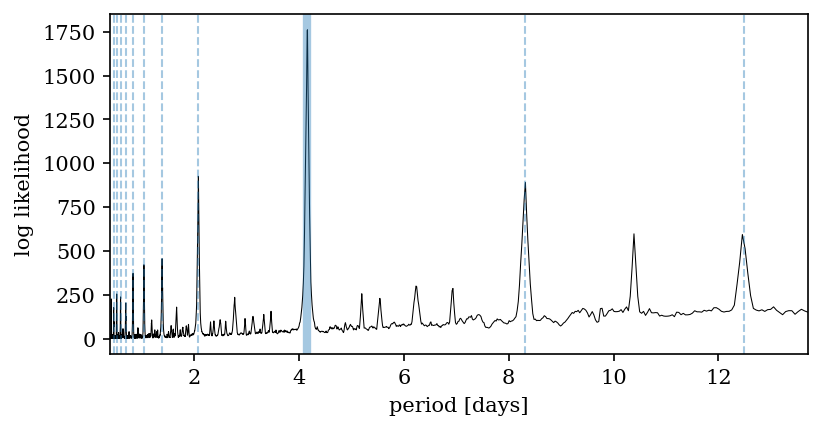

In [28]:
# Find the period of the peak
period = results.period[np.argmax(results.power)]

# Plot the periodogram
rcParams["figure.dpi"] = 150
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(results.period, results.power, "k", lw=0.5)
ax.set_xlim(results.period.min(), results.period.max())
ax.set_xlabel("period [days]")
ax.set_ylabel("log likelihood")

# Highlight the harmonics of the peak period
ax.axvline(period, alpha=0.4, lw=4)
for n in range(2, 10):
    ax.axvline(n*period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(period / n, alpha=0.4, lw=1, linestyle="dashed")